In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `CutMixSemantic` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerRandom, HoleMakerBounded, HoleMakerAttention
from semantic_segmentation_augmentations.holesfilling import CutMixSemantic

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "CutMixSemantic"
}

In order to know how does this technique work, we can show an example:

This technique removes the information of a class in a selected region cut from another image and inserted in the final one.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


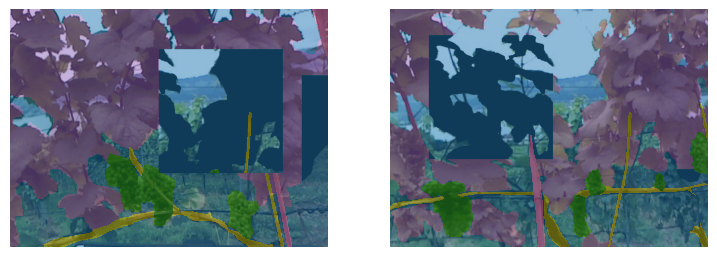

In [ ]:
cms = CutMixSemantic(holes_num = 2, occlusion_class = 2, hole_maker = HoleMakerRandom((250, 250)), p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cms) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cms.x, cms.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for holes_num in [1, 2]:
    for size in [(150, 150), (250, 250)]:
        for holemaker in [HoleMakerBounded, HoleMakerAttention]:
            cms = CutMixSemantic(holes_num = holes_num, hole_maker = holemaker(hole_size = size))
            learner_hparams["cbs"] = [esc, cms]
            r = evaluate(db_hparams,
                         dls_hparams,
                         technique,
                         learner_hparams,
                         learning_hparams,
                         learning_mode,
                         saving_hparams,
                         verbose = True
                        )
            results.update({
                str(holes_num) + str(size) + str(holemaker).split("'")[1].split(".")[2]: r["DiceMulti"]
            })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.927845,0.615582,0.335905,00:21
1,0.669017,0.493262,0.346618,00:19
2,0.890055,0.950971,0.233990,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.550016,0.474604,0.347266,00:20
1,0.455167,0.406721,0.483230,00:19
2,0.424295,0.385564,0.552786,00:19
3,0.394462,0.384824,0.556745,00:20
4,0.365525,0.378964,0.618863,00:19
5,0.335997,0.306988,0.758430,00:19
6,0.331086,0.383435,0.675828,00:19
7,0.322588,0.335343,0.771155,00:19
8,0.305023,0.336452,0.759683,00:20
9,0.296937,0.312046,0.774746,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.19902798533439636  /  DiceMulti: 0.8483878154589582  
Saving best model because DiceMulti 0.8484 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.026082,0.665627,0.333319,00:19
1,0.727671,0.455651,0.348907,00:19
2,0.754358,0.490681,0.345763,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.447130,0.398826,0.383872,00:19
1,0.410013,0.348916,0.546465,00:19
2,0.374753,0.307332,0.671129,00:20
3,0.338948,0.278846,0.774972,00:20
4,0.312820,0.273565,0.767440,00:20
5,0.301163,0.283685,0.754815,00:20
6,0.301101,0.257633,0.803162,00:20
7,0.292006,0.315927,0.750877,00:20
8,0.290849,0.249365,0.793880,00:20
9,0.287670,0.251347,0.809215,00:19


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.18659181892871857  /  DiceMulti: 0.8488813718513232  
Saving best model because DiceMulti 0.8489 >= 0.8484.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.970685,0.678039,0.330974,00:19
1,0.796490,0.440665,0.348946,00:19
2,0.676734,0.397358,0.472379,00:19


epoch,train_loss,valid_loss,dice_multi,time
0,0.380371,0.364698,0.581545,00:20
1,0.356538,0.314778,0.647503,00:20
2,0.345980,0.311943,0.657100,00:20
3,0.328401,0.296290,0.765504,00:20
4,0.307566,0.296372,0.705842,00:20
5,0.294738,0.300034,0.768782,00:20
6,0.280770,0.280849,0.799215,00:20
7,0.285805,0.291899,0.766979,00:20
8,0.277601,0.296963,0.798729,00:20
9,0.274399,0.260195,0.812735,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.17251934111118317  /  DiceMulti: 0.8592569887803215  
Saving best model because DiceMulti 0.8593 >= 0.8489.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.067340,0.781793,0.320788,00:20
1,0.779600,0.397987,0.356827,00:20
2,0.623687,0.365234,0.511232,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.401290,0.271738,0.553175,00:20
1,0.383783,0.267590,0.698269,00:20
2,0.366939,0.260570,0.688064,00:20
3,0.355861,0.274266,0.761434,00:20
4,0.334335,0.236873,0.775108,00:20
5,0.333265,0.262401,0.677647,00:20
6,0.336232,0.257439,0.790679,00:20
7,0.314481,0.235939,0.706656,00:20
8,0.300913,0.237815,0.759383,00:20
9,0.302935,0.233819,0.822492,00:20


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.22981512546539307  /  DiceMulti: 0.8357338277901153  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.833440,0.639949,0.320540,00:20
1,0.634610,0.710034,0.292255,00:20
2,0.800973,0.887183,0.277578,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.542896,0.511567,0.353607,00:20
1,0.475821,0.428415,0.402699,00:20
2,0.433312,0.357652,0.526005,00:20
3,0.391857,0.321905,0.643201,00:20
4,0.369731,0.315475,0.699320,00:20
5,0.341884,0.299227,0.759916,00:20
6,0.324864,0.290015,0.767925,00:20
7,0.316251,0.309954,0.742346,00:20
8,0.316979,0.294430,0.764185,00:20
9,0.309887,0.290299,0.758439,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.21233582496643066  /  DiceMulti: 0.8103007190015269  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.917524,0.948282,0.256991,00:19
1,0.633385,0.723066,0.361702,00:20
2,0.750223,0.962652,0.250860,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.512039,0.509949,0.377276,00:20
1,0.430675,0.551954,0.454632,00:20
2,0.389322,0.436155,0.565073,00:20
3,0.354918,0.468421,0.616175,00:20
4,0.332224,0.444841,0.645861,00:20
5,0.323400,0.422802,0.630364,00:20
6,0.314551,0.428303,0.620194,00:20
7,0.314297,0.451239,0.676993,00:20
8,0.296399,0.400872,0.721554,00:20
9,0.272960,0.414911,0.715532,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.19937273859977722  /  DiceMulti: 0.8400685190288124  
Saving best model because DiceMulti 0.8401 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.039943,0.600418,0.350539,00:19
1,0.776909,0.469723,0.351567,00:20
2,0.621453,0.453437,0.373913,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.422143,0.347349,0.549651,00:20
1,0.370263,0.308067,0.720574,00:20
2,0.346790,0.353017,0.734640,00:20
3,0.345415,0.309379,0.712982,00:20
4,0.333249,0.293222,0.795698,00:20
5,0.343479,0.287304,0.794575,00:20
6,0.326913,0.319696,0.770519,00:20
7,0.315852,0.291586,0.766107,00:20
8,0.293946,0.267567,0.810785,00:20
9,0.295428,0.264057,0.819025,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.20909574627876282  /  DiceMulti: 0.858041973671123  
Saving best model because DiceMulti 0.858 >= 0.8401.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.970569,0.886932,0.233205,00:20
1,0.711605,0.410919,0.354767,00:20
2,0.848601,0.782179,0.289211,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.526137,0.395875,0.389485,00:20
1,0.459790,0.385289,0.391020,00:20
2,0.433004,0.355333,0.598920,00:20
3,0.397264,0.348157,0.488801,00:20
4,0.376391,0.328739,0.634351,00:20
5,0.347921,0.303834,0.735963,00:20
6,0.328035,0.319147,0.747974,00:20
7,0.316918,0.313285,0.741256,00:20
8,0.310877,0.276970,0.796392,00:20
9,0.292245,0.286168,0.775128,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.1822824627161026  /  DiceMulti: 0.8608959499157823  
Saving best model because DiceMulti 0.8609 >= 0.858.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.902494,0.512813,0.352857,00:20
1,0.677807,0.468750,0.359001,00:20
2,0.698938,0.697203,0.345397,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.477209,0.333247,0.436464,00:20
1,0.426854,0.275850,0.605006,00:20
2,0.401081,0.324781,0.624116,00:20
3,0.382740,0.243403,0.787915,00:20
4,0.355554,0.237821,0.790549,00:20
5,0.345636,0.269361,0.715500,00:20
6,0.334330,0.260285,0.787585,00:20
7,0.323889,0.274718,0.789981,00:20
8,0.318372,0.259153,0.806949,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.26723217964172363  /  DiceMulti: 0.8107580703360313  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.940650,0.717123,0.321898,00:20
1,0.687961,0.685184,0.302384,00:20
2,0.566062,0.413128,0.518903,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.364325,0.322955,0.708916,00:20
1,0.339095,0.285836,0.773728,00:20
2,0.320914,0.352553,0.764466,00:20
3,0.314720,0.283016,0.772667,00:20
4,0.310929,0.283995,0.738848,00:20
5,0.304139,0.270238,0.783469,00:20
6,0.301785,0.288822,0.804926,00:20
7,0.313554,0.315976,0.804362,00:20
8,0.304008,0.267100,0.824045,00:20
9,0.286052,0.249739,0.823742,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.24871617555618286  /  DiceMulti: 0.8042089473887835  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.296103,0.770270,0.308725,00:20
1,0.816319,0.619491,0.321602,00:20
2,0.640753,0.708756,0.306918,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.389470,0.421307,0.529113,00:20
1,0.361311,0.406250,0.627902,00:20
2,0.333267,0.472454,0.621376,00:21
3,0.307943,0.411753,0.691134,00:21
4,0.287312,0.464167,0.694566,00:20
5,0.281879,0.507766,0.696323,00:20
6,0.273751,0.465140,0.697380,00:20


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.239601269364357  /  DiceMulti: 0.79972935056258  
Saving best model because DiceMulti 0.7997 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.954837,0.705070,0.320257,00:20
1,0.765452,0.523340,0.344717,00:20
2,0.660148,0.501164,0.341252,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.444215,0.392707,0.414846,00:20
1,0.407416,0.344904,0.551694,00:20
2,0.376889,0.322564,0.686416,00:20
3,0.356754,0.346379,0.590573,00:20
4,0.349346,0.407410,0.578309,00:20
5,0.352232,0.322521,0.624561,00:20
6,0.340235,0.310966,0.697438,00:20
7,0.326385,0.308373,0.771023,00:20
8,0.321478,0.304622,0.778851,00:21
9,0.302874,0.275707,0.780213,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.18093349039554596  /  DiceMulti: 0.8651986878252028  
Saving best model because DiceMulti 0.8652 >= 0.7997.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.891082,0.655314,0.333462,00:20
1,0.697854,0.645561,0.312072,00:20
2,1.282431,11.913045,0.135202,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,1.915361,0.406443,0.446091,00:20
1,0.920506,0.377575,0.488510,00:20
2,0.598086,0.344653,0.637370,00:20
3,0.465875,0.309892,0.600292,00:20
4,0.396149,0.394970,0.714819,00:20
5,0.365170,0.331953,0.691911,00:21
6,0.339887,0.308023,0.755464,00:20
7,0.323062,0.278177,0.755729,00:21
8,0.302427,0.293961,0.726457,00:20
9,0.297522,0.301731,0.791014,00:20


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.22869041562080383  /  DiceMulti: 0.8396927037550611  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.977565,0.656344,0.307136,00:20
1,0.714721,0.487728,0.347493,00:20
2,1.189266,1.337816,0.211092,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.679955,0.397886,0.359330,00:20
1,0.540131,0.350456,0.361273,00:20
2,0.470587,0.291939,0.503295,00:21
3,0.424481,0.284780,0.522491,00:20
4,0.393923,0.271017,0.614321,00:20
5,0.365354,0.255809,0.720295,00:20
6,0.351522,0.248771,0.783199,00:20
7,0.332748,0.243261,0.756150,00:20
8,0.321620,0.280645,0.746060,00:20
9,0.313312,0.246812,0.739121,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.1765434443950653  /  DiceMulti: 0.866827916240893  
Saving best model because DiceMulti 0.8668 >= 0.8652.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.026695,0.674469,0.338423,00:20
1,0.688125,0.478982,0.355039,00:20
2,0.927232,1.952174,0.135947,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.780807,0.600745,0.343247,00:20
1,0.569574,0.418207,0.365308,00:21
2,0.478160,0.418107,0.400121,00:20
3,0.416711,0.338933,0.589267,00:20
4,0.380433,0.326008,0.620354,00:21
5,0.355148,0.327670,0.766569,00:21
6,0.333325,0.281919,0.766226,00:20
7,0.315195,0.288970,0.725326,00:21
8,0.301824,0.293197,0.720628,00:20
9,0.286767,0.284129,0.799903,00:20


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.20805029571056366  /  DiceMulti: 0.8120644299965878  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.056135,0.668761,0.293165,00:20
1,0.796756,0.681034,0.306809,00:20
2,1.040182,0.962136,0.231177,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.633289,0.552874,0.327100,00:20
1,0.516831,0.550648,0.331467,00:20
2,0.450454,0.478098,0.403805,00:20
3,0.419083,0.424417,0.540313,00:20
4,0.374967,0.463376,0.649363,00:20
5,0.343457,0.458489,0.642344,00:20
6,0.324945,0.667714,0.670559,00:20
7,0.299672,0.431892,0.710478,00:20
8,0.279197,0.472158,0.687747,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.22891487181186676  /  DiceMulti: 0.8098778956412241  
Saving best model because DiceMulti 0.8099 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.098178,0.735755,0.305556,00:20
1,0.856679,0.770578,0.312530,00:20
2,0.937686,2.561501,0.136446,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.798074,0.533233,0.344571,00:20
1,0.576664,0.421417,0.355953,00:20
2,0.486173,0.375124,0.414154,00:20
3,0.428276,0.341205,0.561857,00:20
4,0.424158,0.359995,0.523961,00:20
5,0.407589,0.399105,0.560004,00:20
6,0.395158,0.445295,0.502983,00:20
7,0.393653,0.326447,0.712471,00:20
8,0.365971,0.349643,0.683629,00:20
9,0.339565,0.287103,0.751158,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.20918898284435272  /  DiceMulti: 0.8359496114520907  
Saving best model because DiceMulti 0.8359 >= 0.8099.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.852837,0.601098,0.317341,00:20
1,0.626049,0.501641,0.425129,00:20
2,0.799540,2.416923,0.134324,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.803318,0.464169,0.346785,00:20
1,0.581218,0.433613,0.350883,00:20
2,0.499690,0.430351,0.496265,00:20
3,0.438060,0.345931,0.594554,00:20
4,0.394897,0.342884,0.641713,00:20
5,0.366999,0.365707,0.723750,00:20
6,0.352946,0.409859,0.686514,00:20
7,0.339562,0.293362,0.730586,00:20
8,0.323761,0.286883,0.762797,00:20
9,0.300422,0.272280,0.778345,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.19283464550971985  /  DiceMulti: 0.8532975898372854  
Saving best model because DiceMulti 0.8533 >= 0.8359.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.976682,0.652522,0.351729,00:20
1,0.710655,0.350978,0.361820,00:20
2,0.630471,0.395738,0.415160,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.433542,0.281335,0.640617,00:20
1,0.390655,0.270273,0.635854,00:20
2,0.361486,0.262833,0.721439,00:20
3,0.341987,0.238490,0.791800,00:20
4,0.322657,0.230887,0.800369,00:20
5,0.311209,0.305398,0.766161,00:20
6,0.310364,0.265531,0.754069,00:20
7,0.305847,0.248164,0.812886,00:20
8,0.299091,0.232613,0.817668,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.2413647323846817  /  DiceMulti: 0.8290733440582729  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.084853,0.712732,0.303702,00:19
1,0.752648,0.492677,0.359323,00:20
2,0.788550,0.822609,0.300745,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.491963,0.439265,0.354609,00:20
1,0.436661,0.373923,0.538973,00:20
2,0.386638,0.339767,0.583758,00:20
3,0.378716,0.342296,0.544059,00:20
4,0.352999,0.310444,0.715470,00:20
5,0.336100,0.280737,0.780571,00:20
6,0.316885,0.277030,0.780225,00:20
7,0.305369,0.317853,0.735504,00:20
8,0.297955,0.265835,0.762278,00:20
9,0.308061,0.278856,0.812781,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.257327139377594  /  DiceMulti: 0.7816262431429787  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.017739,0.652114,0.301950,00:20
1,0.717152,0.559469,0.326976,00:20
2,0.580750,0.488063,0.428114,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.373763,0.413629,0.598795,00:20
1,0.343311,0.403268,0.628185,00:20
2,0.317750,0.395114,0.670183,00:20
3,0.302092,0.390267,0.670123,00:20
4,0.289849,0.521270,0.675231,00:20
5,0.287495,0.377902,0.724214,00:20
6,0.291338,0.395166,0.722283,00:20
7,0.285425,0.375411,0.725121,00:20
8,0.297859,0.400543,0.723523,00:20
9,0.282383,0.489846,0.705887,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.223567932844162  /  DiceMulti: 0.8354127141429807  
Saving best model because DiceMulti 0.8354 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.083328,0.920854,0.302885,00:20
1,0.748419,0.401519,0.400065,00:20
2,0.598875,0.442647,0.448245,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.386738,0.329586,0.608983,00:20
1,0.362646,0.309274,0.626206,00:20
2,0.347904,0.362497,0.736443,00:20
3,0.334758,0.328987,0.666161,00:20
4,0.329171,0.280359,0.792919,00:20
5,0.325748,0.368351,0.720848,00:20
6,0.310235,0.263958,0.786700,00:20
7,0.305002,0.272604,0.798246,00:20
8,0.291105,0.263556,0.807030,00:20
9,0.289756,0.302148,0.769435,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.23326970636844635  /  DiceMulti: 0.8031951358805882  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.287509,0.709956,0.326785,00:19
1,0.834574,0.553907,0.329904,00:20
2,0.756745,0.691873,0.300493,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.453295,0.364524,0.515257,00:20
1,0.399556,0.325992,0.636155,00:20
2,0.361151,0.311884,0.703326,00:20
3,0.344661,0.304490,0.716724,00:20
4,0.328138,0.348311,0.722043,00:20
5,0.317054,0.309055,0.687114,00:20
6,0.301893,0.273200,0.790572,00:20
7,0.305503,0.304302,0.596522,00:20
8,0.294352,0.282245,0.768205,00:20
9,0.284371,0.287914,0.792181,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.2047644704580307  /  DiceMulti: 0.852185694217237  
Saving best model because DiceMulti 0.8522 >= 0.8354.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.054591,0.657320,0.319948,00:20
1,0.779389,0.457296,0.355343,00:20
2,0.643140,0.358846,0.362979,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.449740,0.344791,0.584478,00:20
1,0.406798,0.269358,0.662860,00:20
2,0.380019,0.260330,0.748375,00:20
3,0.346160,0.232641,0.802025,00:20
4,0.331321,0.245297,0.775123,00:20
5,0.323510,0.261475,0.809918,00:20
6,0.313494,0.243745,0.777187,00:20
7,0.308173,0.228951,0.795141,00:21
8,0.304350,0.404826,0.660984,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.41262286901474  /  DiceMulti: 0.6922950462924311  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.856298,0.658894,0.340357,00:20
1,0.723098,0.782959,0.272961,00:20
2,0.689584,0.525541,0.344774,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.452213,0.451853,0.513163,00:20
1,0.413539,0.389782,0.535397,00:20
2,0.389364,0.387167,0.564167,00:20
3,0.360633,0.312788,0.595618,00:21
4,0.345609,0.287122,0.769395,00:20
5,0.335605,0.296156,0.732931,00:20
6,0.319398,0.262346,0.798102,00:20
7,0.303204,0.275803,0.789861,00:20
8,0.300803,0.262867,0.805446,00:20
9,0.288194,0.279556,0.766706,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.3382953703403473  /  DiceMulti: 0.7724107017227524  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.885515,0.589574,0.333819,00:20
1,0.606756,0.581003,0.388546,00:20
2,0.853568,0.751487,0.276297,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.499739,0.515386,0.330328,00:20
1,0.420359,0.444325,0.455612,00:20
2,0.384338,0.485506,0.509689,00:20
3,0.363910,0.550038,0.529383,00:20
4,0.329124,0.529139,0.672933,00:21
5,0.306166,0.629061,0.654033,00:20
6,0.319089,0.403304,0.672399,00:20
7,0.302691,0.540128,0.672102,00:20
8,0.289345,0.581044,0.682746,00:20
9,0.285880,0.408533,0.710124,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.21816983819007874  /  DiceMulti: 0.8425105707815795  
Saving best model because DiceMulti 0.8425 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.058789,0.824350,0.331266,00:20
1,0.953587,0.994041,0.269428,00:20
2,0.980799,0.828341,0.137593,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.530177,0.427245,0.383938,00:21
1,0.462471,0.376911,0.426044,00:20
2,0.417724,0.353599,0.464081,00:20
3,0.396594,0.323458,0.656286,00:20
4,0.368134,0.317960,0.639216,00:20
5,0.357410,0.347715,0.669815,00:20
6,0.352943,0.362704,0.617730,00:21
7,0.350055,0.343243,0.731274,00:20
8,0.329213,0.322235,0.765852,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.3032529950141907  /  DiceMulti: 0.7676746867525697  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.019194,0.724357,0.320870,00:20
1,0.734366,0.479951,0.352276,00:20
2,0.750181,0.574135,0.380281,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.441009,0.371462,0.464455,00:20
1,0.411230,0.371778,0.573241,00:20
2,0.378291,0.352039,0.546652,00:21
3,0.364229,0.330615,0.556230,00:21
4,0.335170,0.284906,0.768772,00:20
5,0.330130,0.324628,0.759532,00:20
6,0.333286,0.290891,0.763079,00:20
7,0.322332,0.320007,0.713822,00:20
8,0.310198,0.281581,0.782512,00:20
9,0.290264,0.298411,0.776779,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.2240748554468155  /  DiceMulti: 0.7963383068423646  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.854854,0.613974,0.355943,00:20
1,0.667963,0.694410,0.307482,00:20
2,0.602458,0.352629,0.480585,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.427788,0.293264,0.608264,00:20
1,0.399646,0.281294,0.625529,00:20
2,0.367618,0.253151,0.774889,00:20
3,0.344751,0.257165,0.804707,00:20
4,0.325658,0.272599,0.773095,00:20
5,0.317915,0.278997,0.740895,00:20
6,0.311101,0.234050,0.797527,00:20
7,0.300617,0.226264,0.822547,00:20
8,0.305113,0.246841,0.812944,00:20
9,0.289014,0.214377,0.830263,00:20


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.18539708852767944  /  DiceMulti: 0.8634737486786846  
Saving best model because DiceMulti 0.8635 >= 0.8425.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.208654,0.962257,0.164540,00:20
1,0.833399,0.518417,0.347022,00:20
2,0.661370,0.511862,0.353421,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.410480,0.367774,0.544283,00:20
1,0.371065,0.383428,0.570618,00:20
2,0.345758,0.330501,0.714036,00:20
3,0.339018,0.276161,0.756140,00:20
4,0.325882,0.312394,0.686662,00:20
5,0.334709,0.309804,0.710674,00:20
6,0.319520,0.281511,0.797780,00:20
7,0.324944,0.296526,0.798080,00:20
8,0.312828,0.424376,0.760285,00:20


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.4857657551765442  /  DiceMulti: 0.7108346744502638  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.998565,0.722865,0.293600,00:20
1,0.710423,0.706138,0.287743,00:20
2,1.255506,0.910856,0.235754,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.685639,0.617697,0.316824,00:20
1,0.559770,0.496178,0.339531,00:20
2,0.492194,0.699058,0.298642,00:20
3,0.453754,0.528688,0.364730,00:21
4,0.413181,0.574190,0.472263,00:20
5,0.376026,0.416326,0.614719,00:21
6,0.334349,0.394062,0.634896,00:20
7,0.340262,0.421342,0.595871,00:20
8,0.315615,0.574319,0.631733,00:20
9,0.313514,0.456934,0.682642,00:20


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.24407893419265747  /  DiceMulti: 0.7864888409883247  
Saving best model because DiceMulti 0.7865 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.941904,0.999204,0.235126,00:20
1,0.765774,0.537897,0.342403,00:20
2,0.811467,0.947080,0.239446,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.573800,0.471338,0.349570,00:20
1,0.518768,0.514038,0.368203,00:20
2,0.459669,0.364292,0.537295,00:20
3,0.424509,0.347424,0.636478,00:20
4,0.402619,0.411636,0.649462,00:20
5,0.376272,0.315688,0.643643,00:20
6,0.356950,0.295520,0.745738,00:20
7,0.349921,0.303237,0.598892,00:20
8,0.338086,0.275368,0.787808,00:20
9,0.326287,0.327547,0.753872,00:20


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.19117359817028046  /  DiceMulti: 0.8525472342470835  
Saving best model because DiceMulti 0.8525 >= 0.7865.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.994322,0.610140,0.332412,00:20
1,0.841525,0.688844,0.324367,00:20
2,0.724562,0.441373,0.349338,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.420647,0.374209,0.401644,00:20
1,0.407756,0.339968,0.584397,00:20
2,0.375337,0.342176,0.664824,00:20
3,0.357513,0.319333,0.680415,00:20
4,0.346099,0.325268,0.673717,00:20
5,0.334351,0.408557,0.637514,00:20
6,0.340361,0.325721,0.768877,00:20
7,0.324895,0.298857,0.749709,00:21
8,0.303455,0.302972,0.732909,00:21
9,0.294206,0.279941,0.778806,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.1985708475112915  /  DiceMulti: 0.8288945220701234  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.931207,0.568991,0.333515,00:20
1,0.710695,0.469448,0.352504,00:20
2,0.599073,0.479775,0.427378,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.423222,0.298468,0.535205,00:20
1,0.393839,0.263386,0.625841,00:20
2,0.360560,0.247463,0.745171,00:20
3,0.330457,0.232536,0.804786,00:21
4,0.329530,0.288059,0.797792,00:21
5,0.332861,0.258047,0.715290,00:20
6,0.321769,0.236561,0.790555,00:21
7,0.304272,0.255388,0.808122,00:21
8,0.295823,0.331751,0.788703,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.33762097358703613  /  DiceMulti: 0.798229781123207  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.999587,0.636144,0.324488,00:20
1,0.762306,0.749895,0.336523,00:20
2,0.650231,0.615697,0.342255,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.422848,0.399139,0.396072,00:21
1,0.383060,0.346838,0.612470,00:21
2,0.367627,0.313191,0.752920,00:21
3,0.349400,0.291930,0.751193,00:20
4,0.329667,0.297005,0.737350,00:21
5,0.323831,0.311183,0.737472,00:21
6,0.310354,0.272854,0.791978,00:20
7,0.308699,0.303723,0.767557,00:20
8,0.299105,0.280973,0.806874,00:21
9,0.278769,0.258649,0.808719,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.2421923726797104  /  DiceMulti: 0.8046872216023075  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.767645,0.730583,0.294691,00:20
1,0.603341,0.519877,0.340563,00:20
2,0.549798,0.870033,0.167237,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.389812,0.439293,0.521980,00:21
1,0.347402,0.449854,0.597993,00:21
2,0.325747,0.408796,0.646804,00:20
3,0.305469,0.437248,0.709836,00:21
4,0.290404,0.413500,0.675041,00:21
5,0.278415,0.385222,0.692857,00:20
6,0.270291,0.625213,0.689067,00:20
7,0.270954,0.407278,0.669889,00:21
8,0.282702,0.411064,0.706120,00:21
9,0.284544,0.499201,0.705293,00:20


No improvement since epoch 5: early stopping


Test results for the model.   validation: 0.2088131159543991  /  DiceMulti: 0.8318847105589731  
Saving best model because DiceMulti 0.8319 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.026829,0.918565,0.225235,00:20
1,0.784758,0.422201,0.353691,00:20
2,0.773592,0.704512,0.311705,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.476690,0.405254,0.355557,00:20
1,0.428175,0.378656,0.403290,00:21
2,0.394778,0.322895,0.589678,00:20
3,0.374159,0.348616,0.562201,00:21
4,0.346601,0.329248,0.740957,00:20
5,0.340987,0.320069,0.777838,00:20
6,0.316050,0.298319,0.765768,00:20
7,0.314510,0.312888,0.770072,00:20
8,0.303359,0.365958,0.752128,00:20
9,0.303946,0.386527,0.706372,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.17460596561431885  /  DiceMulti: 0.8722596521918243  
Saving best model because DiceMulti 0.8723 >= 0.8319.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.843258,0.724676,0.300484,00:20
1,0.683703,0.810614,0.310647,00:20
2,0.659021,0.528535,0.339553,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.462806,0.377459,0.396157,00:21
1,0.398422,0.341970,0.552585,00:21
2,0.382250,0.347751,0.535117,00:20
3,0.366040,0.355839,0.577927,00:20
4,0.342999,0.328495,0.691283,00:20
5,0.342761,0.294450,0.745742,00:20
6,0.326677,0.354412,0.679554,00:20
7,0.323339,0.308025,0.772686,00:21
8,0.298843,0.276621,0.786643,00:20
9,0.278828,0.264951,0.801927,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.1828814595937729  /  DiceMulti: 0.8591204228430553  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.045622,0.819828,0.280517,00:20
1,0.832838,0.407788,0.355798,00:20
2,1.120275,1.043067,0.176827,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.626452,0.431507,0.350943,00:20
1,0.528253,0.396036,0.359308,00:20
2,0.472111,0.324822,0.411147,00:20
3,0.434536,0.282647,0.488874,00:20
4,0.402662,0.274053,0.594532,00:21
5,0.382145,0.307865,0.710119,00:21
6,0.366578,0.253602,0.764509,00:20
7,0.338807,0.236820,0.789096,00:21
8,0.344418,0.247919,0.763912,00:20
9,0.326714,0.259624,0.785169,00:20


No improvement since epoch 16: early stopping


Test results for the model.   validation: 0.19215542078018188  /  DiceMulti: 0.8404862157882784  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.926298,0.717216,0.330516,00:20
1,0.853106,0.925616,0.200909,00:20
2,0.975107,0.970607,0.214895,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.536048,0.495435,0.347699,00:21
1,0.458615,0.427759,0.362232,00:21
2,0.423532,0.382523,0.403099,00:21
3,0.396169,0.348993,0.542790,00:20
4,0.373933,0.335540,0.591754,00:21
5,0.350984,0.312259,0.679155,00:20
6,0.352968,0.327345,0.687185,00:21
7,0.335747,0.282103,0.773295,00:20
8,0.317653,0.307503,0.749596,00:20
9,0.309949,0.290807,0.740066,00:20


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.21446678042411804  /  DiceMulti: 0.8135932465126551  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,"1(150, 150)HoleMakerBounded","1(150, 150)HoleMakerAttention","1(250, 250)HoleMakerBounded","1(250, 250)HoleMakerAttention","2(150, 150)HoleMakerBounded","2(150, 150)HoleMakerAttention","2(250, 250)HoleMakerBounded","2(250, 250)HoleMakerAttention"
0,0.848388,0.840069,0.799729,0.809878,0.835413,0.842511,0.786489,0.831885
1,0.848881,0.858042,0.865199,0.835950,0.803195,0.767675,0.852547,0.872260
2,0.859257,0.860896,0.839693,0.853298,0.852186,0.796338,0.828895,0.859120
3,0.835734,0.810758,0.866828,0.829073,0.692295,0.863474,0.798230,0.840486
4,0.810301,0.804209,0.812064,0.781626,0.772411,0.710835,0.804687,0.813593


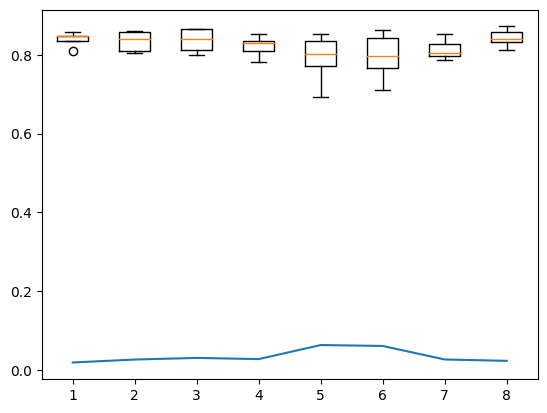

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
"1(150, 150)HoleMakerBounded",0.840512,0.018835
"1(150, 150)HoleMakerAttention",0.834795,0.026281
"1(250, 250)HoleMakerBounded",0.836703,0.030424
"1(250, 250)HoleMakerAttention",0.821965,0.027391
"2(150, 150)HoleMakerBounded",0.791100,0.063153
"2(150, 150)HoleMakerAttention",0.796166,0.060769
"2(250, 250)HoleMakerBounded",0.814170,0.026457
"2(250, 250)HoleMakerAttention",0.843469,0.022965


We save the results in order to plot them together.

In [ ]:
folds = [["CMS" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("CutMixSemantic")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


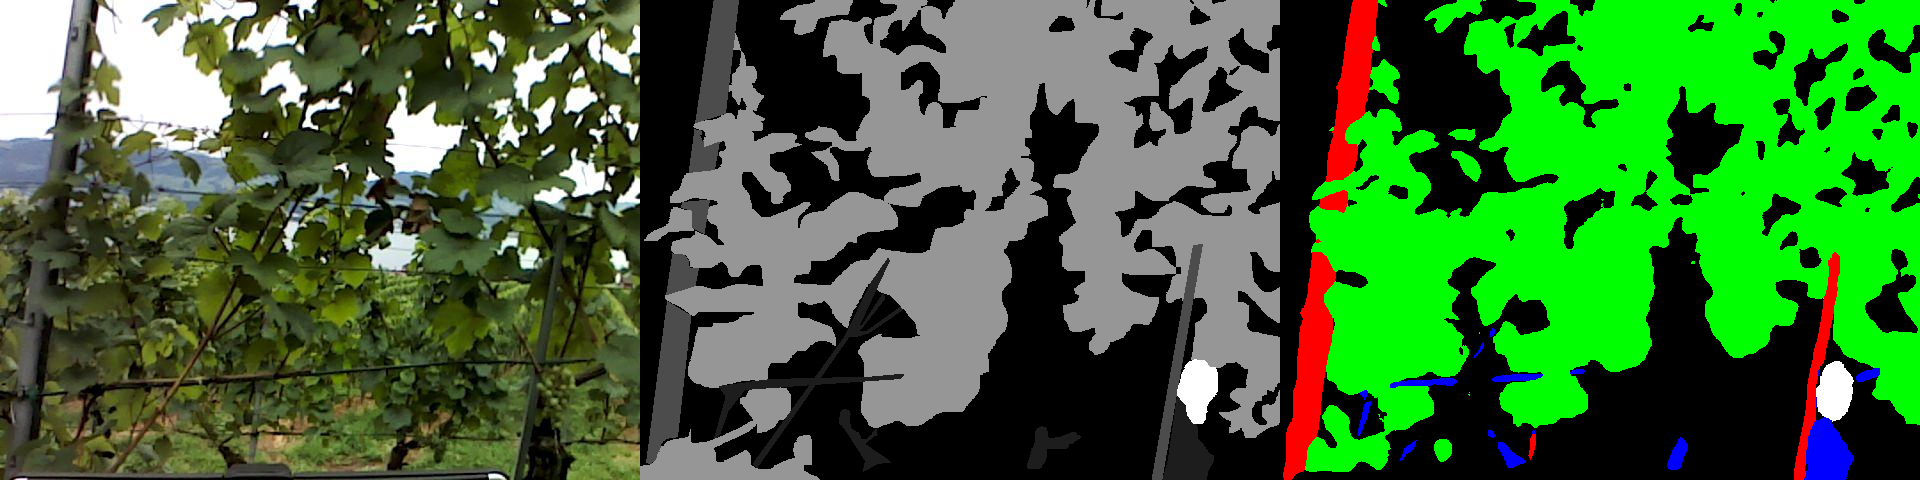

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

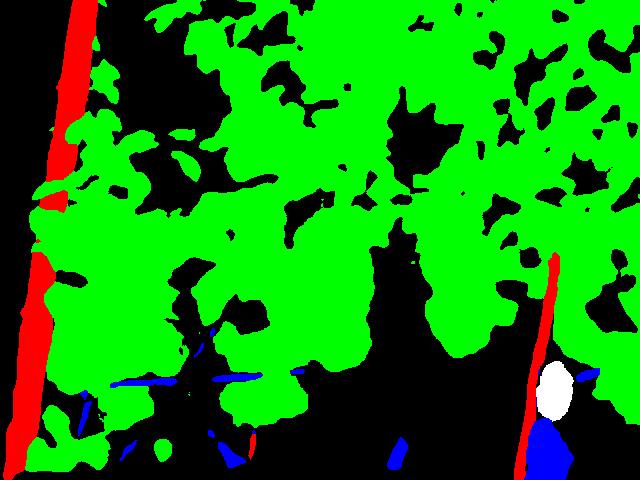

In [ ]:
mask